# Unet Implementation in PyTorch

In [1]:
from fastai2.vision.all import *

## Data

In [2]:
path = untar_data(URLs.CAMVID)
Path.BASE_PATH = path
path.ls()

(#5) [Path('codes.txt'),Path('images'),Path('valid.txt'),Path('models'),Path('labels')]

In [3]:
files = get_image_files(path/'images')
files

(#701) [Path('images/0001TP_007770.png'),Path('images/0001TP_007740.png'),Path('images/0016E5_07650.png'),Path('images/Seq05VD_f02010.png'),Path('images/0001TP_009000.png'),Path('images/0001TP_010140.png'),Path('images/0016E5_08009.png'),Path('images/0001TP_008970.png'),Path('images/Seq05VD_f02280.png'),Path('images/Seq05VD_f04740.png')...]

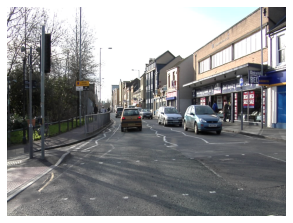

In [4]:
img = PILImage.create(files[59])
img.show();

In [5]:
img.shape

(720, 960)

In [6]:
img.shape[0]//2, img.shape[1]//2

(360, 480)

get label

In [7]:
def get_y(f):
    return path/'labels'/f'{f.stem}_P{f.suffix}'

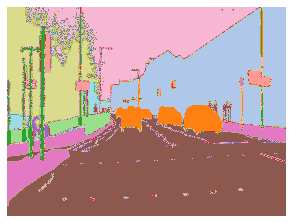

In [8]:
img_mask = PILMask.create(get_y(files[59]))
img_mask.show(alpha=5);

In [9]:
valid_files = (path/'valid.txt').read().split('\n')

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [11]:
def ListSplitter(valid_files):
    def _inner(o):
        val_mask = tensor([file.name in valid_files for file in o ])
        return [~val_mask, val_mask]
    return _inner

In [12]:
db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    get_y=get_y,
    splitter=ListSplitter(valid_files),
    batch_tfms=[*aug_transforms(size=(360,480)),
                Normalize.from_stats(*imagenet_stats)])

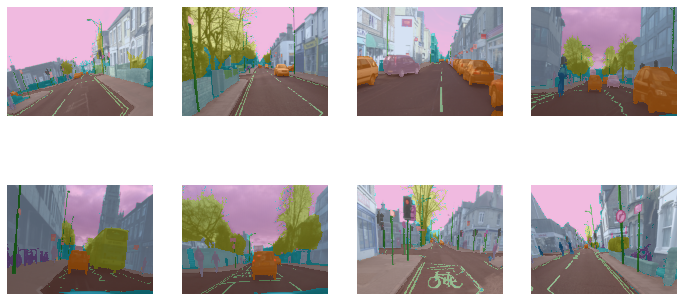

In [13]:
dls = db.dataloaders(path/'images', bs=8)
dls.show_batch()

In [14]:
dls.vocab = codes

## Define unet model

In [15]:
def conv_layer(in_channels, out_channels, ks, stride=1, padding=0, act=True):
    # create a sequence of a Conv2d layer with an optional activation function
    layer = [nn.Conv2d(in_channels, out_channels, ks, 
                       stride=stride, padding=padding)]
    if act: layer.append(nn.ReLU())
    return nn.Sequential(*layer)

In [16]:
def conv_block(in_channels, out_channels):
    # a block consists of two 3x3 convolutions each folowed by a relu activation
    block = [conv_layer(in_channels, out_channels, 3),
             conv_layer(out_channels, out_channels, 3)]
    return nn.Sequential(*block)

In [17]:
def transpose_conv(in_channels, ks, stride=2, padding=0, act=True):
    # create a sequence of a transpose Conv2d layer with an optional activation function
    layer = [nn.ConvTranspose2d(in_channels, in_channels//2,  ks,
                                stride=stride, padding=padding)]
    if act: layer.append(nn.ReLU())
    return nn.Sequential(*layer)

In [18]:
def center_crop(input, target_height, target_width):
    start_height = (input.shape[-2] - target_height) // 2 - 1
    start_width = (input.shape[-1] - target_width) // 2 - 1
    return input[..., start_height:start_height+target_height, 
                 start_width:start_width+target_width]

In [19]:
class DecoderBlock(Module):
    def __init__(self, in_channels, out_channels):
        self.tc = transpose_conv(in_channels, 2)
        self.convs = conv_block(in_channels, out_channels)
        
    def forward(self, x, hook):
        upsample = self.tc(x)
        hook_cropped = center_crop(hook, upsample.shape[2], upsample.shape[3])
        return self.convs(torch.cat((hook_cropped, upsample), dim=1))

In [20]:
class Unet(Module):
    def __init__(self, n_out):
        # encoder
        self.eb1 = conv_block(3, 64) # first block in the encoder
        self.eb2 = conv_block(64, 128)
        self.eb3 = conv_block(128, 256)
        self.eb4 = conv_block(256, 512)
        self.eb5 = conv_block(512, 1024)
        
        self.max_pool = nn.MaxPool2d(2,2)
        # decoder
        self.db1 = DecoderBlock(1024, 512)
        self.db2 = DecoderBlock(512, 256)
        self.db3 = DecoderBlock(256, 128)
        self.db4 = DecoderBlock(128, 64)
        
        self.final_conv = conv_layer(64, n_out, 1, act=False)
    
    def forward(self, x):
        hook1 = self.eb1(x)
        hook2 = self.eb2(self.max_pool(hook1))
        hook3 = self.eb3(self.max_pool(hook2))
        hook4 = self.eb4(self.max_pool(hook3))
        encoder_output = self.eb5(self.max_pool(hook4))
    
        # decoder
        up1 = self.db1(encoder_output, hook4)
        up2 = self.db2(up1, hook3)       
        up3 = self.db3(up2, hook2)       
        up4 = self.db4(up3, hook1)
        
        # final
        out = self.final_conv(up4)
        return out

train model

In [21]:
unet = Unet(len(codes))

In [22]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

In [23]:
def acc_camvid(preds, targ):
    """
    the shape of the predicted mask is less than the target because of the unpadded
    convolutions so the target mask is center cropped to fit the size of the predictions
    """ 
    targ = center_crop(targ, *preds.shape[2:])
    mask = targ != void_code
    return (preds.argmax(dim=1)[mask] == targ[mask]).float().mean()

In [24]:
def loss_function(preds, targ):
    """
    the shape of the predicted mask is less than the target because of the unpadded
    convolutions so the target mask is center cropped to fit the size of the predictions
    """ 
    targ = center_crop(targ, *preds.shape[2:])
    return F.cross_entropy(preds, targ)

In [25]:
learn = Learner(dls, unet, loss_func=loss_function, metrics=acc_camvid)

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0005754399462603033)

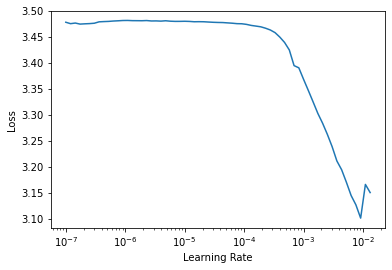

In [26]:
learn.lr_find()

In [27]:
learn.fit_one_cycle(20, 2e-3)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.735195,2.420976,0.315371,00:46
1,2.142206,2.210219,0.369845,00:41
2,1.850253,1.941971,0.461912,00:41
3,1.735503,1.844924,0.515130,00:41
4,1.610840,1.785514,0.470060,00:41
5,1.479728,1.985697,0.423049,00:41
6,1.388823,1.505013,0.470767,00:41
7,1.275284,1.535409,0.530110,00:41
8,1.213714,1.381743,0.590775,00:41
9,1.181958,1.301425,0.645399,00:42


## Add batchnorm to every cnn layer 

In [28]:
def conv_layer(in_channels, out_channels, ks, stride=1, padding=0, bn=True, act=True):
    # create a sequence of a Conv2d layer with an optional activation function
    layer = [nn.Conv2d(in_channels, out_channels, ks, 
                       stride=stride, padding=padding)]
    if bn: layer.append(nn.BatchNorm2d(out_channels))
    if act: layer.append(nn.ReLU())
    return nn.Sequential(*layer)

In [31]:
def conv_block(in_channels, out_channels, bn=True):
    # a block consists of two 3x3 convolutions each folowed by a relu activation
    block = [conv_layer(in_channels, out_channels, 3, bn=bn),
             conv_layer(out_channels, out_channels, 3, bn=bn)]
    return nn.Sequential(*block)

In [32]:
def transpose_conv(in_channels, ks, stride=2, padding=0, act=True):
    # create a sequence of a transpose Conv2d layer with an optional activation function
    layer = [nn.ConvTranspose2d(in_channels, in_channels//2,  ks,
                                stride=stride, padding=padding),
             nn.BatchNorm2d(in_channels//2)]
    if act: layer.append(nn.ReLU())
    return nn.Sequential(*layer)

In [33]:
class DecoderBlock(Module):
    def __init__(self, in_channels, out_channels):
        self.tc = transpose_conv(in_channels, 2)
        self.convs = conv_block(in_channels, out_channels, bn=True)
        
    def forward(self, x, hook):
        upsample = self.tc(x)
        hook_cropped = center_crop(hook, upsample.shape[2], upsample.shape[3])
        return self.convs(torch.cat((hook_cropped, upsample), dim=1))

In [35]:
class Unet(Module):
    def __init__(self, n_out):
        # encoder
        self.eb1 = conv_block(3, 64, bn=True) # first block in the encoder
        self.eb2 = conv_block(64, 128, bn=True)
        self.eb3 = conv_block(128, 256, bn=True)
        self.eb4 = conv_block(256, 512, bn=True)
        self.eb5 = conv_block(512, 1024, bn=True)
        
        self.max_pool = nn.MaxPool2d(2,2)
        # decoder
        self.db1 = DecoderBlock(1024, 512)
        self.db2 = DecoderBlock(512, 256)
        self.db3 = DecoderBlock(256, 128)
        self.db4 = DecoderBlock(128, 64)
        
        self.final_conv = conv_layer(64, n_out, 1, bn=False,
                                     act=False)
    
    def forward(self, x):
        hook1 = self.eb1(x)
        hook2 = self.eb2(self.max_pool(hook1))
        hook3 = self.eb3(self.max_pool(hook2))
        hook4 = self.eb4(self.max_pool(hook3))
        encoder_output = self.eb5(self.max_pool(hook4))
    
        # decoder
        up1 = self.db1(encoder_output, hook4)
        up2 = self.db2(up1, hook3)       
        up3 = self.db3(up2, hook2)       
        up4 = self.db4(up3, hook1)
        
        # final
        out = self.final_conv(up4)
        return out

In [36]:
get_c(dls)

32

In [43]:
unet = Unet(len(codes))

In [44]:
learn = Learner(dls, unet, loss_func=loss_function, metrics=acc_camvid)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.015848932787775993)

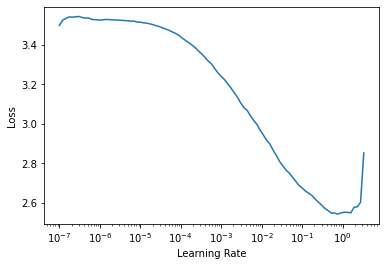

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(20, 2e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.805560,2.276243,0.496002,00:47
1,1.480459,4.023126,0.361130,00:47
2,1.326817,3.026443,0.495356,00:47
3,1.278611,2.245638,0.458842,00:47
4,1.313100,1.700977,0.582594,00:47
5,1.204033,1.752940,0.494350,00:47
6,1.121728,2.561114,0.446545,00:47
7,1.043798,1.256064,0.637893,00:47
8,0.985960,1.201667,0.655428,00:47
9,0.936125,1.968539,0.641084,00:47
